In [2]:
from IPython.core.display import HTML, Image
css_file = '../../../../msc/custom.css' 
HTML(open(css_file, 'r').read()) 

# The Generalized Roy Model

**Roadmap**

* Data Generating Process
* Objects of Interest
* Processing Specification
* Setting up Simulation
* Conducting Estimation
* Inspection of Results

Over the next couple of lectures, we will then constantly refine the basic code and explore elements of software engineering such as Object-Oriented Programming, Unit Testing, Debugging, and Profiling.

Before we get started, let us import some basic libraries.

In [3]:
# Unix Pattern Extensions
import glob

# Operating System Interfaces
import os

# Lexical Analysis
import shlex

# Copy operations
import copy

# Statistical Modeling and Econometrics  
import statsmodels.api as sm

# Plotting 
import matplotlib.pyplot as plt
%pylab inline --no-import-all

# Scientific Computing 
import numpy as np
from scipy.stats    import norm
from scipy.optimize import minimize


Populating the interactive namespace from numpy and matplotlib


## Processing of Model Specification

We manage the model specification in an external text file, which is called *init.ini*. This file will turn out to be useful to provide the parameters for a simulation of a synthetic sample or the initialization of starting values for an estimation.

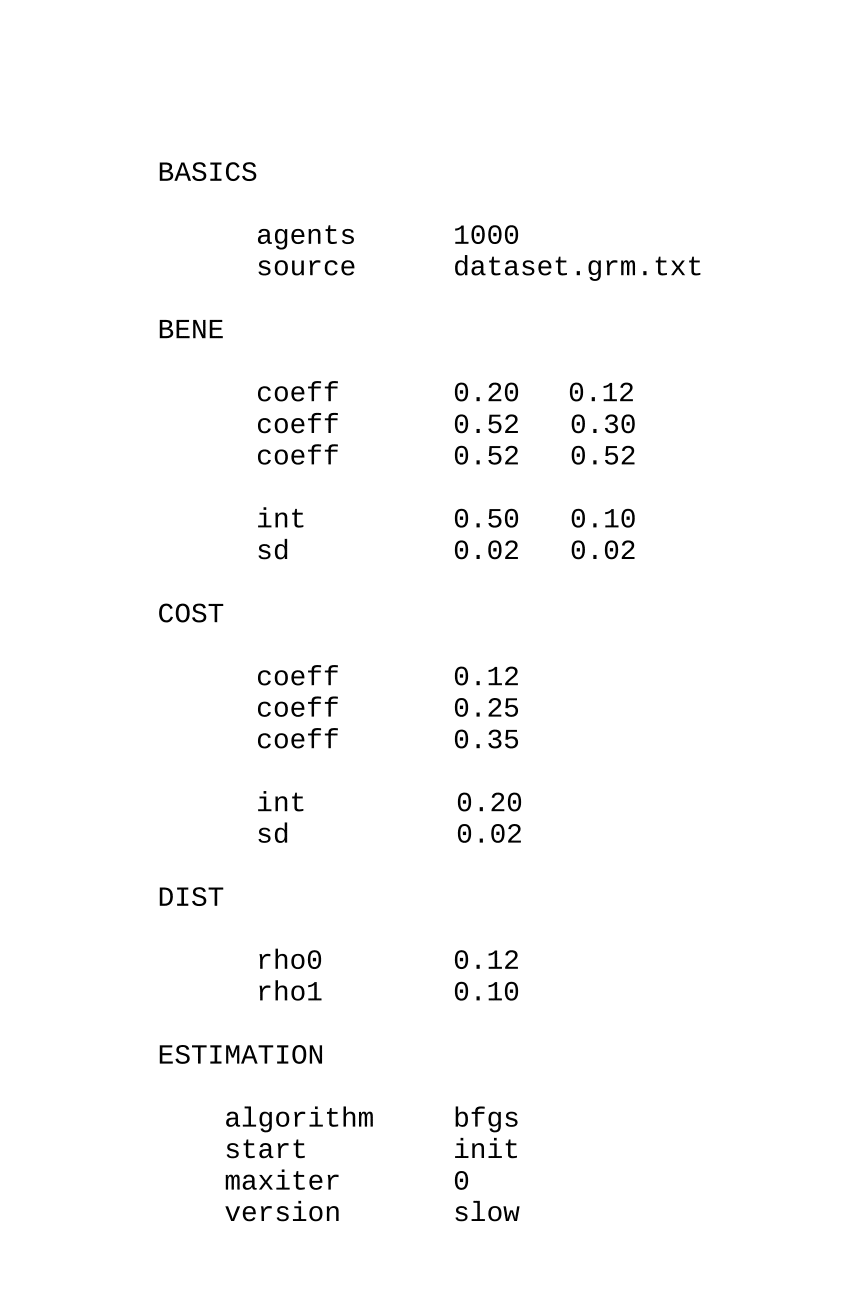

In [5]:
Image(filename='images/init.png', width=1000)

Now we will develop a set of function that processes the initialization file.

In [36]:
def _check_integrity_process(dict_):
    """ Check integrity of initFile dict.
    """
    # Antibugging
    assert (isinstance(dict_, dict))

    # Check number of agents
    assert (dict_['BASICS']['agents'] > 0)
    assert (isinstance(dict_['BASICS']['agents'], int))

    # Check optimizer
    assert (dict_['ESTIMATION']['algorithm'] in ['bfgs', 'nm'])

    # Check starting values
    assert (dict_['ESTIMATION']['start'] in ['random', 'init'])

    # Maximum iterations
    assert (dict_['ESTIMATION']['maxiter'] >= 0)

    # Finishing
    return True


def _add_auxiliary(dict_):
    """ Add some auxiliary objects.
    """
    # Antibugging
    assert (isinstance(dict_, dict))

    # Initialize container
    dict_['AUX'] = {}

    # Full set of coefficients.
    dict_['TREATED']['all'] = [dict_['TREATED']['int']]
    dict_['TREATED']['all'] += dict_['TREATED']['coeff']
    dict_['TREATED']['all'] = np.array(dict_['TREATED']['all'])

    dict_['UNTREATED']['all'] = [dict_['UNTREATED']['int']]
    dict_['UNTREATED']['all'] += dict_['UNTREATED']['coeff']
    dict_['UNTREATED']['all'] = np.array(dict_['UNTREATED']['all'])

    dict_['COST']['all'] = np.array(dict_['COST']['coeff'])

    # Number of covariates
    num_covars_out = len(dict_['TREATED']['coeff']) + 1
    num_covars_cost = len(dict_['COST']['coeff'])

    dict_['AUX']['num_covars_out'] = num_covars_out
    dict_['AUX']['num_covars_cost'] = num_covars_cost

    # Number of parameters
    dict_['AUX']['num_paras'] = 2 * num_covars_out + num_covars_cost + 2 + 2

    # Starting values
    dict_['AUX']['init_values'] = []
    dict_['AUX']['init_values'] += [dict_['TREATED']['int']]
    dict_['AUX']['init_values'] += dict_['TREATED']['coeff']
    dict_['AUX']['init_values'] += [dict_['UNTREATED']['int']]
    dict_['AUX']['init_values'] += dict_['UNTREATED']['coeff']
    dict_['AUX']['init_values'] += dict_['COST']['coeff']
    dict_['AUX']['init_values'] += [dict_['TREATED']['sd']]
    dict_['AUX']['init_values'] += [dict_['UNTREATED']['sd']]
    dict_['AUX']['init_values'] += [dict_['DIST']['rho1']]
    dict_['AUX']['init_values'] += [dict_['DIST']['rho0']]

    # Finishing
    return dict_


def _process_cases(list_):
    """ Process cases and determine whether keyword or empty
        line.
    """
    # Antibugging
    assert (isinstance(list_, list))

    # Get information
    is_empty = (len(list_) == 0)

    if not is_empty:
        is_keyword = list_[0].isupper()
    else:
        is_keyword = False

    # Antibugging
    assert (is_keyword in [True, False])
    assert (is_empty in [True, False])

    # Finishing
    return is_empty, is_keyword


In [39]:
def process(file_):
    """ Process initialization file.
    """
    # Initialization
    dict_ = {}

    for line in open(file_).readlines():

        list_ = shlex.split(line)

        # Determine special cases
        is_empty, is_keyword = _process_cases(list_)

        # Applicability
        if is_empty:
            continue

        if is_keyword:
            keyword = list_[0]
            dict_[keyword] = {}
            continue

        if keyword not in ['BENE']:
            dict_ = _process_not_bene(list_, dict_, keyword)

        else:
            dict_ = _process_bene(list_, dict_, keyword)

    # Remove BENE
    del dict_['BENE']

    # Add auxiliary objects
    dict_ = _add_auxiliary(dict_)

    # Check quality.
    _check_integrity_process(dict_)

    # Finishing.
    return dict_

def _process_bene(list_, dict_, keyword):
    """ This function processes the BENE part of the initialization file.
    """
    # Distribute information
    name, val_treated, val_untreated = list_[0], list_[1], list_[2]

    # Initialize dictionary
    if 'TREATED' not in dict_.keys():
        for subgroup in ['TREATED', 'UNTREATED']:
            dict_[subgroup] = {}
            dict_[subgroup]['coeff'] = []
            dict_[subgroup]['int'] = None
            dict_[subgroup]['sd'] = None

    # Type conversion
    val_treated = float(val_treated)
    val_untreated = float(val_untreated)

    # Collect information
    if name in ['coeff']:
        dict_['TREATED'][name] += [val_treated]
        dict_['UNTREATED'][name] += [val_untreated]
    else:
        dict_['TREATED'][name] = val_treated
        dict_['UNTREATED'][name] = val_untreated

    # Finishing
    return dict_


def _process_not_bene(list_, dict_, keyword):
    """ This function processes all of the initialization file, but the
        BENE section.
    """
    # Distribute information
    name, val = list_[0], list_[1]

    # Prepare container.
    if name not in dict_[keyword].keys():
        if name in ['coeff']:
            dict_[keyword][name] = []

    # Type conversion
    if name in ['agents', 'maxiter']:
        val = int(val)
    elif name in ['source', 'algorithm', 'start', 'version']:
        val = str(val)
    else:
        val = float(val)

    # Collect information
    if name in ['coeff']:
        dict_[keyword][name] += [val]
    else:
        dict_[keyword][name] = val

    # Finishing.
    return dict_


Let us check if it is all working.

In [40]:
init_dict = process('init.ini')

# Setting up the Simulation

**Distributinal Assumptions**

*Observables*

\begin{align}
X & \sim \mathbb{N}(0, 1) \\
Z & \sim \mathbb{N}(0, 1) \\
\end{align}

*Unobservables*  

\begin{eqnarray*}
\begin{pmatrix}U_{1}\\
U_{0}\\
V
\end{pmatrix} & \sim & \mathbb{N}\left[\left(\begin{array}{c}
0\\
0\\
0
\end{array}\right),\left(\begin{array}{ccc}
\sigma_{U_1}^2 & 0 & \sigma_{U_1,V}\\
0 & \sigma_{U_0}^2 & \sigma_{U_0,V}\\
\sigma_{U_1,V} & \sigma_{U_0,V} & \sigma_{V}^2
\end{array}\right)\right]\\
\end{eqnarray*}

In [41]:
init_dict = process('init.ini')

In [42]:
def _check_integrity_simulate(Y1, Y0, Y, D):
    """ Check quality of simulated sample.
    """
    assert (np.all(np.isfinite(Y1)))
    assert (np.all(np.isfinite(Y0)))

    assert (np.all(np.isfinite(Y)))
    assert (np.all(np.isfinite(D)))

    assert (Y1.dtype == 'float')
    assert (Y0.dtype == 'float')

    assert (Y.dtype == 'float')
    assert (D.dtype == 'float')

    assert (D.all() in [1.0, 0.0])


def _write_out(Y, D, X, Z, source, unobserved=False, Y1=None, Y0=None):
    """ Write out simulated data to file.
    """

    if not unobserved:

        np.savetxt(source, np.column_stack((Y, D, X, Z)), fmt='%8.3f')

    else:

        assert (isinstance(Y1, np.ndarray))
        assert (isinstance(Y0, np.ndarray))

        np.savetxt(source, np.column_stack((Y, D, X, Z, Y1, Y0)),
                   fmt='%8.3f')

In [43]:
def simulate(init_dict, unobserved=False):
    """ Simulate a model based on the initialization file.
    """

    # Antibugging
    assert (isinstance(init_dict, dict))
    assert (unobserved in [True, False])

    # Ensure recomputability
    np.random.seed(123)

    # Distribute information
    num_agents = init_dict['BASICS']['agents']
    source = init_dict['BASICS']['source']

    Y1_coeffs = init_dict['TREATED']['all']
    Y0_coeffs = init_dict['UNTREATED']['all']

    C_coeffs = np.array(init_dict['COST']['coeff'])

    U1_sd = init_dict['TREATED']['sd']
    U0_sd = init_dict['UNTREATED']['sd']

    V_sd = init_dict['COST']['sd']

    U1V_rho = init_dict['DIST']['rho1']
    U0V_rho = init_dict['DIST']['rho0']

    # Auxiliary objects
    U1V_cov = U1V_rho * U1_sd * V_sd
    U0V_cov = U0V_rho * U0_sd * V_sd

    num_covars_out = Y1_coeffs.shape[0]
    num_covars_cost = C_coeffs.shape[0]

    # Simulate observables
    means = np.tile(0.0, num_covars_out)
    covs = np.identity(num_covars_out)

    X = np.random.multivariate_normal(means, covs, num_agents)
    X[:, 0] = 1.0

    means = np.tile(0.0, num_covars_cost)
    covs = np.identity(num_covars_cost)

    Z = np.random.multivariate_normal(means, covs, num_agents)

    # Construct index of observable characteristics
    Y1_level = np.dot(Y1_coeffs, X.T)
    Y0_level = np.dot(Y0_coeffs, X.T)
    C_level = np.dot(C_coeffs, Z.T)

    # Simulate unobservables
    means = np.tile(0.0, 3)
    vars_ = [U1_sd**2, U0_sd**2, V_sd**2]
    covs = np.diag(vars_)

    covs[0, 2] = U1V_cov
    covs[2, 0] = covs[0, 2]

    covs[1, 2] = U0V_cov
    covs[2, 1] = covs[1, 2]

    U = np.random.multivariate_normal(means, covs, num_agents)

    # Simulate endogenous variables
    Y1 = np.tile(np.nan, num_agents)
    Y0 = np.tile(np.nan, num_agents)
    Y = np.tile(np.nan, num_agents)

    D = np.tile(np.nan, num_agents)

    for i in range(num_agents):

        # Select individual unobservables and observables
        u1, u0, v = U[i, 0], U[i, 1], U[i, 2]

        y1_idx, y0_idx, c_idx = Y1_level[i], Y0_level[i], C_level[i]

        # Decision Rule
        expected_benefits = y1_idx - y0_idx
        cost = c_idx + v

        d = np.float((expected_benefits - cost > 0))

        # Potential outcomes
        y1, y0 = y1_idx + u1, y0_idx + u0

        # Observed outcomes
        y = d * y1 + (1.0 - d) * y0

        # Collect data matrices
        Y[i], Y0[i], Y1[i], D[i] = y, y1, y0, d

    # Check integrity of simulated data
    _check_integrity_simulate(Y1, Y0, Y, D)

    # Save to disk
    _write_out(Y, D, X, Z, source, unobserved, Y1, Y0)

    # Return selected features of data
    return Y1, Y0, D


Let us check if it is all working.

In [44]:
init_dict = process('init.ini')

Y1, Y0, D = simulate(init_dict)


Given our parametrization, let us revisit our objects of interest. We start with the individual-specific benefits. Please note the use of the [StatsModels](http://statsmodels.sourceforge.net/devel/index.html) library,
that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. Think of it as a replacement for using [R](http://www.r-project.org/). In general, [rpy2](http://rpy.sourceforge.net/rpy2.html) provides a low-level interface to R from Python.


Average Treatment Effects

     ATE       -0.40

     TT        -0.44

     TUT       -0.26



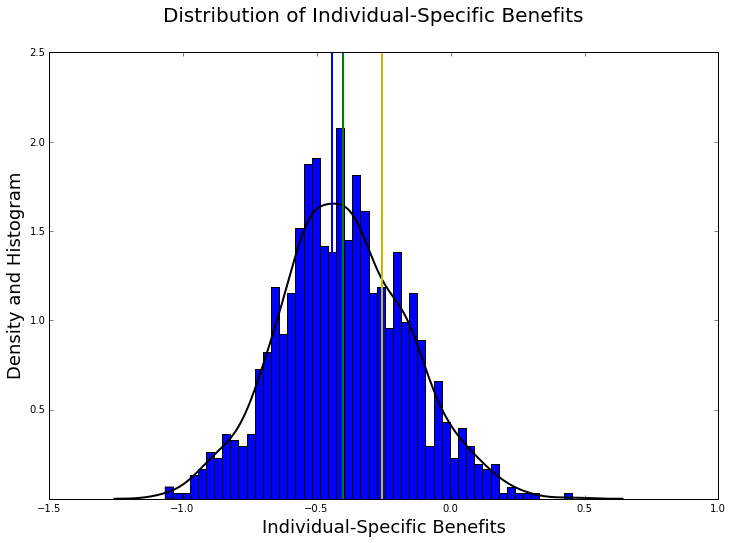

In [45]:
# Auxiliary variables
B = Y1 - Y0

# Create histogram and density estimate of benefits.
kde = sm.nonparametric.KDEUnivariate(B)
kde.fit()

# Initialize canvas
ax = plt.figure(figsize=(12,8)).add_subplot(111)

# Plot histogram and density
ax.hist(B, bins=50, normed=True, color='blue')
ax.plot(kde.support, kde.density, lw=2, color='black')

# Set axis labels
ax.set_xlabel('Individual-Specific Benefits', fontsize=18)
ax.set_ylabel('Density and Histogram', fontsize=18)

# Remove first element on y-axis
ax.yaxis.get_major_ticks()[0].set_visible(False)

# Calcuate the average treatment effects
ate, tt, tut = np.mean(B), np.mean(B[D==1]), np.mean(B[D==0])

# Pretty formatting of strings and output
fmt = '     {0:<5}{1:10.2f}\n'

print '\nAverage Treatment Effects\n'
print fmt.format('ATE ', ate)
print fmt.format('TT', tt)
print fmt.format('TUT ', tut)

# Let us add them to our plot.
plt.axvline(x=ate, ymin=0, ymax=5, linewidth=2, color='g')
plt.axvline(x=tt, ymin=0, ymax=5, linewidth=2, color='b')
plt.axvline(x=tut, ymin=0, ymax=5, linewidth=2, color='y')

# Add title
plt.suptitle('Distribution of Individual-Specific Benefits', fontsize=20)

## Estimation

Now, we will perform Maximum Likelihood Estimation using alternative optimization algorithms. Here is the likelihood function:

\begin{align}
\mathcal{L}(\theta; X, Z) =\sum^N_{i=1} D\mathcal{L_{i,1}} + (1 - D)\mathcal{L_{i,0}},
\end{align}

where

\begin{align}
\mathcal{L_1} = & \log\left(\frac{1}{\sigma_{U_1}}\phi\left(\frac{Y_i - X_i\beta_1}{\sigma_{U_1}}\right)\Phi\left(\frac{Z_i\gamma - \sigma_V/\sigma_{U_1}(Y_i - X_i\beta_1)}{\sqrt{(1 - \rho_{U_1,V})*\sigma^2_{V}}}\right)\right) \\
\mathcal{L_0} =  &\log\left(\frac{1}{\sigma_{U_0}}\phi\left(\frac{Y_i - X_i\beta_0}{\sigma_{U_0}}\right)\Phi\left(\frac{Z_i\gamma - \sigma_V/\sigma_{U_0}(Y_i - X_i\beta_0)}{\sqrt{(1 - \rho_{U_0,V})*\sigma^2_{V}}}\right)\right) \\
\end{align}

In [46]:
def _distribute_parameters(x, init_dict, num_covars_out):
    """ Distribute the parameters.
    """
    # Antibugging
    assert (isinstance(x, np.ndarray))
    assert (isinstance(num_covars_out, int))
    assert (num_covars_out > 0)

    # Initialize containers
    rslt = dict()

    rslt['TREATED'] = dict()
    rslt['UNTREATED'] = dict()
    rslt['COST'] = dict()
    rslt['DIST'] = dict()

    # Distribute parameters
    rslt['TREATED']['all'] = x[:num_covars_out]
    rslt['UNTREATED']['all'] = x[num_covars_out:(2 * num_covars_out)]

    rslt['COST']['all'] = x[(2 * num_covars_out):(-4)]
    rslt['COST']['sd'] = init_dict['COST']['sd']


    rslt['TREATED']['sd'] = np.exp(x[(-4)])
    rslt['UNTREATED']['sd'] = np.exp(x[(-3)])

    rslt['DIST']['rho1'] = -1.0 + 2.0 / (1.0 + float(np.exp(-x[-2])))
    rslt['DIST']['rho0'] = -1.0 + 2.0 / (1.0 + float(np.exp(-x[-1])))

    # Update auxiliary versions
    rslt['AUX'] = dict()

    rslt['AUX']['x_internal'] = x.copy()
    rslt['AUX']['x_internal'][-4] = np.exp(x[(-4)])
    rslt['AUX']['x_internal'][-3] = np.exp(x[(-3)])
    rslt['AUX']['x_internal'][-2] = -1.0 + 2.0 / (1.0 + float(np.exp(-x[-2])))
    rslt['AUX']['x_internal'][-1] = -1.0 + 2.0 / (1.0 + float(np.exp(-x[-1])))

    rslt['AUX']['init_values'] = init_dict['AUX']['init_values']

    # Finishing.
    return rslt


def _max_interface(x, Y, D, X, Z, init_dict):
    """ Interface to the SciPy maximization routines.
    """
    # Auxiliary objects
    num_covars_out = X.shape[1]

    # Collect maximization arguments
    rslt = _distribute_parameters(x, init_dict, num_covars_out)

    # Calculate likelihood
    likl = _negative_log_likelihood(rslt, Y, D, X, Z)

    # Finishing.
    return likl


def _negative_log_likelihood(args, Y, D, X, Z):
    """ Negative Log-likelihood function of the generalized Roy model.
    """
    # Distribute arguments
    Y1_coeffs, Y0_coeffs, C_coeffs, choice_coeffs, U1_sd, U0_sd, U1V_rho, \
    U0V_rho, V_sd = _distribute_arguments(args)

    # Auxiliary objects
    num_agents = Y.shape[0]

    # Initialize containers
    likl = np.tile(np.nan, num_agents)
    choice_idx = np.tile(np.nan, num_agents)

    # Likelihood construction.
    for i in range(num_agents):

        g = np.concatenate((X[i, :], Z[i, :]))
        choice_idx[i] = np.dot(choice_coeffs, g)

        # Select outcome information
        if D[i] == 1.00:

            coeffs, rho, sd = Y1_coeffs, U1V_rho, U1_sd
        else:
            coeffs, rho, sd = Y0_coeffs, U0V_rho, U0_sd

        arg_one = (Y[i] - np.dot(coeffs, X[i, :])) / sd
        arg_two = (choice_idx[i] - rho * V_sd * arg_one) / \
                  np.sqrt((1.0 - rho ** 2) * V_sd**2)

        pdf_evals, cdf_evals = norm.pdf(arg_one), norm.cdf(arg_two)

        if D[i] == 1.0:
            contrib = (1.0 / float(sd)) * pdf_evals * cdf_evals
        else:
            contrib = (1.0 / float(sd)) * pdf_evals * (1.0 - cdf_evals)

        likl[i] = contrib

    # Transformations.
    likl = -np.mean(np.log(np.clip(likl, 1e-20, np.inf)))

    # Quality checks.
    assert (isinstance(likl, float))
    assert (np.isfinite(likl))

    # Finishing.
    return likl


def _load_data(init_dict):
    """ Load dataset.
    """
    # Auxiliary objects
    num_covars_out = init_dict['AUX']['num_covars_out']
    num_covars_cost = init_dict['AUX']['num_covars_cost']
    num_agents = init_dict['BASICS']['agents']

    # Read dataset
    data = np.genfromtxt(init_dict['BASICS']['source'])

    # Reshaping, this ensure that the program also runs with just one agent
    # as otherwise only an vector is created. This creates problems for the
    # subsetting of the overall data into the components.
    data = np.array(data, ndmin=2)

    # Distribute data
    Y, D = data[:, 0], data[:, 1]

    X, Z = data[:, 2:(num_covars_out + 2)], data[:, -num_covars_cost:]

    # Finishing
    return Y, D, X, Z


def _get_start(which, init_dict):
    """ Get different kind of starting values.
    """
    # Antibugging.
    assert (which in ['random', 'init'])

    # Distribute auxiliary objects
    num_paras = init_dict['AUX']['num_paras']

    # Select relevant values.
    if which == 'random':
        x0 = np.random.uniform(size=num_paras)

        # Variances
        x0[(-4)] = max(x0[(-4)], 0.01)
        x0[(-3)] = max(x0[(-3)], 0.01)

        # Correlations
        x0[(-2)] -= 0.5
        x0[(-1)] -= 0.5

    elif which == 'init':
        x0 = np.array(init_dict['AUX']['init_values'][:])
    else:
        raise AssertionError

    # Document starting values
    init_dict['AUX']['start_values'] = x0.copy()

    # Transform to real line
    x0 = _transform_start(x0)

    # Type conversion
    x0 = np.array(x0)

    # Quality assurance.
    assert (np.all(np.isfinite(x0)))

    # Finishing.
    return x0


def _transform_start(x):
    """ Transform starting values to cover the whole real line.
    """

    # Coefficients
    x[:(-4)] = x[:(-4)]

    # Variances
    x[(-4)] = np.log(x[(-4)])
    x[(-3)] = np.log(x[(-3)])

    # Correlations
    transform = (x[(-2)] + 1) / 2
    x[(-2)] = np.log(transform / (1.0 - transform))

    transform = (x[(-1)] + 1) / 2
    x[(-1)] = np.log(transform / (1.0 - transform))

    # Finishing
    return x


def _distribute_arguments(args):
    """ Distribute arguments for evaluation of criterion function and some
        auxiliary parameters.
    """
    Y1_coeffs = np.array(args['TREATED']['all'])
    Y0_coeffs = np.array(args['UNTREATED']['all'])

    C_coeffs = np.array(args['COST']['all'])

    U1_sd = args['TREATED']['sd']
    U0_sd = args['UNTREATED']['sd']

    U1V_rho = args['DIST']['rho1']
    U0V_rho = args['DIST']['rho0']
    V_sd = args['COST']['sd']

    choice_coeffs = np.concatenate((Y1_coeffs - Y0_coeffs, - C_coeffs))

    # Finishing
    return Y1_coeffs, Y0_coeffs, C_coeffs, choice_coeffs, U1_sd, U0_sd, \
           U1V_rho, U0V_rho, V_sd

Let us evaluate the criterion function and see if that part is working.

Finally, we create a function for the estimation. It builds on all our previously defined elements.

In [47]:
# Load model information
init_dict  = process('init.ini') 

Y, D, X, Z = _load_data(init_dict)

likl = _negative_log_likelihood(init_dict, Y, D, X, Z)

print 'Evaluation of criterion function', likl

Evaluation of criterion function -2.42130684537


In [48]:
def estimate(init_dict):
    """ Estimate our version of the generalized Roy model.
    """
    # Antibugging
    assert (isinstance(init_dict, dict))

    # Load dataset
    Y, D, X, Z = _load_data(init_dict)

    # Create auxiliary objects
    start = init_dict['ESTIMATION']['start']
    maxiter = init_dict['ESTIMATION']['maxiter']

    optimizer = init_dict['ESTIMATION']['algorithm']
    num_covars_out = init_dict['AUX']['num_covars_out']

    # Initialize different starting values
    x0 = _get_start(start, init_dict)

    # Select optimizer
    if optimizer == 'nm':

        optimizer = 'Nelder-Mead'

    elif optimizer == 'bfgs':

        optimizer = 'BFGS'

    # Provide additional arguments to the optimizer
    opts = dict()

    opts['maxiter'] = maxiter

    # Run optimization or just evaluate function at starting values
    if maxiter == 0:

        # Collect maximization arguments.
        rslt = _distribute_parameters(np.array(x0), init_dict, num_covars_out)

        # Calculate likelihood according to user's request
        likl = _negative_log_likelihood(rslt, Y, D, X, Z)

        # Compile results
        x_rslt, fun, success = x0, likl, False

    else:

        # Check out the SciPy documentation for details about the interface
        # to the `minimize' function that provides a convenient interface to
        # a variety of alternative maximization algorithms. You will also
        # find information about the return information.
        opt_rslt = minimize(_max_interface, x0,
                            args=(Y, D, X, Z, init_dict),
                            method=optimizer, options=opts)

        # Compile results
        x_rslt, fun = opt_rslt['x'], opt_rslt['fun']
        success = opt_rslt['success']

    # Tranformation to internal parameters
    rslt = _distribute_parameters(x_rslt, init_dict, num_covars_out)

    rslt['fval'], rslt['success'] = fun, success

    # Finishing
    return rslt


Now, let us actually run some estimations. Our current implementation allow to easily switch between alternative optimzation algorithms and starting values. 

In [49]:
# Process model specification
init_dict = process('init.ini')

# Simulate a synthetic sample
simulate(init_dict)

# Estimate the generalized Roy model
for algorithm in ['bfgs', 'nm']:
    
    init_dict['ESTIMATION']['algorithm'] = algorithm
    
    for start in ['random', 'init']:
        
        init_dict['ESTIMATION']['start'] = start

        # Monitoring
        print '\n\n Current Request \n'
        
        print ' Algorithm: ', algorithm
        
        print ' Start:     ', start
        
        # Run estimation
        rslt = estimate(init_dict)
        
        # Inspect subset of results
        print ' Variances: ', rslt['TREATED']['sd'], rslt['UNTREATED']['sd']



 Current Request 

 Algorithm:  bfgs
 Start:      random
 Variances:  0.506439832475 0.902768738014


 Current Request 

 Algorithm:  bfgs
 Start:      init
 Variances:  0.02 0.02


 Current Request 

 Algorithm:  nm
 Start:      random
 Variances:  0.33177785397 0.785469855001


 Current Request 

 Algorithm:  nm
 Start:      init
 Variances:  0.02 0.02


## Inspection of Results

After conduction an estimation, the focus shifts back to the economic interpretation of our results. As we often have to study the results from hundreds of different estimation runs, it is convenient to have a function set up that produces the main objects of interest. 

In [50]:
def inspect(rslt, init_dict):
    """ This function simulates a sample from the estimates of the model
        and reports the average effects of treatment in a file.
    """
    # Antibugging
    assert (isinstance(rslt, dict))
    assert (isinstance(init_dict, dict))

    # Update results
    modified_init = copy.deepcopy(init_dict)

    for key_ in rslt.keys():

        if key_ in ['fval', 'success']:
            continue

        for subkey in rslt[key_].keys():

            modified_init[key_][subkey] = rslt[key_][subkey]

    # Modified dataset
    modified_init['BASICS']['file'] = 'simulated.grm.txt'

    # Simulate from estimation results
    Y1, Y0, D = simulate(modified_init, True)

    # Calculate the average treatment effects
    B = Y1 - Y0

    effects = []
    effects += [np.mean(B)]
    effects += [np.mean(B[D == 1])]
    effects += [np.mean(B[D == 0])]

    # Print selected results to file
    with open('results.grm.txt', 'w') as file_:

        file_.write('\n softEcon: Generalized Roy Model')
        file_.write('\n -------------------------------\n')

        # Average effects of treatment
        fmt = '     {0:<5}{1:10.2f}\n\n'

        file_.write('\n Average Treatment Effects\n\n')

        for i, label in enumerate(['ATE', 'TT', 'TUT']):

            str_ = fmt.format(label, effects[i])

            file_.write(str_)

        file_.write('\n Parameters\n\n')
        file_.write('     Start    Finish\n\n')

        num_paras = init_dict['AUX']['num_paras']

        # Structural parameters
        x0, x = init_dict['AUX']['start_values'], rslt['AUX']['x_internal']

        fmt = '{0:10.2f}{1:10.2f}\n'

        for i in range(num_paras):

            str_ = fmt.format(x0[i], x[i])

            file_.write(str_)


Let us try it out.

In [51]:
# Process initialization file
init_dict = process('init.ini')

# Simulate synthetic sample
simulate(init_dict)

# Estimate model
rslt = estimate(init_dict)

# Write results
inspect(rslt, init_dict)

# Inspect the results
%cat results.grm.txt


 softEcon: Generalized Roy Model
 -------------------------------

 Average Treatment Effects

     ATE       -0.40

     TT        -0.44

     TUT       -0.26


 Parameters

     Start    Finish

      0.50      0.50
      0.20      0.20
      0.52      0.52
      0.52      0.52
      0.10      0.10
      0.12      0.12
      0.30      0.30
      0.52      0.52
      0.12      0.12
      0.25      0.25
      0.35      0.35
      0.02      0.02
      0.02      0.02
      0.10      0.10
      0.12      0.12


## Cleanup

In [52]:
# Create list of all files generated the notebook
files = glob.glob('*.grm.*')

# Remove files
for file_ in files:
    
    os.remove(file_)